In [1]:
# set to false when no multiprocessing is available
if True:
    import multiprocess as mp
    cpus = 20
    mp.set_start_method("spawn")

In [2]:
#import libraries
import scipy
import seaborn as sns
import matplotlib.font_manager as font_manager
import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
from scipy.stats import sem
import numpy as np
import hmp 
import xarray as xr
import matplotlib.pyplot as plt
import os
from mne.io import read_info
from datetime import datetime
from statsmodels.stats.descriptivestats import sign_test 
from scipy.stats import ttest_1samp

# get EEG information
epoch_data_path = os.path.join('data/subjects/')                                        #Declaring path where the eeg data is
subj_names = [x.split('.')[0] for x in os.listdir(epoch_data_path) if 'epo.fif' in x]   #Extracting subject name based on the file name
subj_files = [epoch_data_path+x+'.fif' for x in subj_names]                             #Create a list of files that can be read from the folder
info = read_info(subj_files[0], verbose=False)

# load the epoched data and convert to hmp data applying PCA
epoch_data =  hmp.utils.load_data('data/hmp_data/epoch_data.nc')
hmp_data = hmp.utils.transform_data(epoch_data, n_comp=4)

In [3]:
# model initialization parameters to test
parameters = {
    "shape" : [2, 4, 6],
    "location_corr_threshold" : [None, 0.7, 0.4],
    "location_corr_duration" : [200, 300, 400]
}

In [4]:
def get_estimates(shape, location_corr_threshold, location_corr_duration):
    # this if-else-statement only makes the loop execute the model without custom parameters once instead of three times
    if location_corr_threshold == "None" and location_corr_duration != "200":
        return []

    else:
        path_name = "results/general/shape" + str(shape) + \
                    "/location_corr_threshold" + str(location_corr_threshold) + \
                    "/location_corr_duration" + str(location_corr_duration)
        
        return [
            xr.open_dataset(path_name + "/estimates[0].nc"),
            [xr.open_dataset(path_name + "/estimates[1][{0}].nc".format(i)) for i in range (0, 40)]
        ]

In [5]:
# # for sub_path in ["general/", "conditional/A/", "conditional/B/", "conditional/C/", "conditional/D/"]:

# models = {}
# for shape in parameters["shape"]:
#     models["shape" + str(shape)] = {}

# for shape in parameters["shape"]:
#     for location_corr_threshold in parameters["location_corr_threshold"]:
#         models["shape" + str(shape)]["location_corr_threshold" + str(location_corr_threshold)] = {}

# for shape in parameters["shape"]:
#     for location_corr_threshold in parameters["location_corr_threshold"]:
#         for location_corr_duration in parameters["location_corr_duration"]:
#             print("working on model with parameters {0}, {1}, {2}".format(shape, location_corr_threshold, location_corr_duration))
#             models["shape" + str(shape)]["location_corr_threshold" + str(location_corr_threshold)]["location_corr_duration" + str(location_corr_duration)] = \
#             get_estimates(str(shape), str(location_corr_threshold), str(location_corr_duration))

In [6]:
def get_piepies(pvalues, steps):
    # count up in events untill an increase in events does not yield a significant improvement.
    for i, (first_value, second_value) in enumerate(pvalues):
        if second_value >= 0.05:
            return i + steps
    return len(pvalues) + steps

In [7]:
def get_max_event(loocv_estimates):
    loocv_estimates = loocv_estimates.dropna('n_event', how='all')

    # difference between event n and n-1
    diffs = [loocv_estimates.sel(n_event=n).data - loocv_estimates.sel(n_event=n-1).data for n in np.arange(2, loocv_estimates.n_event.max()+1)]
    pvalues = [ttest_1samp(diff, 0, alternative='greater') for diff in diffs]

    # difference between event n and n-2
    diffs2 = [loocv_estimates.sel(n_event=n).data - loocv_estimates.sel(n_event=n-2).data for n in np.arange(3, loocv_estimates.n_event.max()+1)]
    pvalues2 = [ttest_1samp(diff, 0, alternative='greater') for diff in diffs2]
    
    # get maximum number of events where p < 0.05
    m = 1
    for i, (first_value, second_value) in enumerate(pvalues):
        if second_value <= 0.05:
            m += 1
    
    # count up in events untill an increase in events does not yield a significant improvement.
    # we also check whether it is signitificantly benefitial to increase the number of events by two.
    if get_piepies(pvalues, 1) != m:
        return get_piepies(pvalues2, 2)
    else:
        return get_piepies(pvalues, 1)
    

In [8]:
def get_mags_pars(models, e):
    #get average mags and params
    mags = models[0].sel(n_events=e).magnitudes.dropna('event')
    params = models[0].sel(n_events=e).parameters.dropna('stage')

    participants = pp = len(np.unique(models[0].participant.values))
    for pp in range(1, participants):
        mags += models[pp].sel(n_events=e).magnitudes.dropna('event')
        params += models[pp].sel(n_events=e).parameters.dropna('stage')
    mags = mags / participants
    params = params / participants

    return mags, params

In [9]:
def general_loocv_model(init, mags, params, e):
    #fit final model
    return init.fit_single(e, magnitudes=mags,parameters=params)

In [10]:
def cond_loocv_model(init, mags, pars, mapping, e):
    conds = {'event_name': ['A', 'B', 'C', 'D']} 

    if mapping == "full" or e == 3:
        # assuming that the number of events is 3
        mags_map = np.swapaxes(np.array([[1, 2, 3, 4]] * e), 0, 1)
        pars_map = np.swapaxes(np.array([[1, 2, 3, 4]] * (e + 1)), 0, 1)

    elif mapping == "half" and e != 3:
        # assuming that the number of events is 6
        mags_map = np.array([[0, 0, 0, 0, 0, 0],
                             [0, 0, 1, 0, 0, 0],
                             [0, 0, 2, 1, 1, 0],
                             [0, 0, 3, 1, 1, 0]])

        pars_map = np.array([[0, 0, 0, 0, 0, 0, 0],
                             [0, 0, 1, 0, 0, 0, 0],
                             [0, 0, 2, 1, 1, 0, 0],
                             [0, 0, 3, 1, 1, 0, 0]])
    
    return init.fit_single_conds(magnitudes=mags, parameters=pars, mags_map=mags_map, pars_map=pars_map, conds=conds, verbose=False)

In [11]:
def plot_topos(epoch_data, model, info, init):
    hmp.visu.plot_topo_timecourse(epoch_data, model, info, init, magnify=1, sensors=False, event_lines=True, colorbar=True, contours=0)

shape, location_corr_threshold, location_corr_duration, max_events, likelihood
2      None                     200                             3           -102.8
Estimating 3 events model
parameters estimated for 3 events model


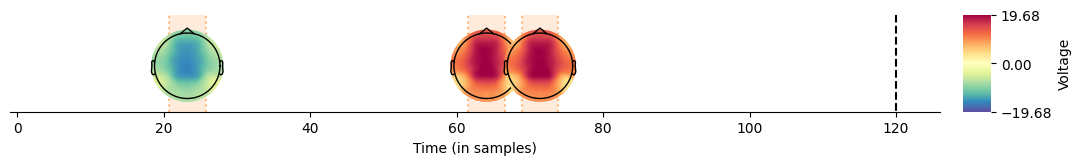

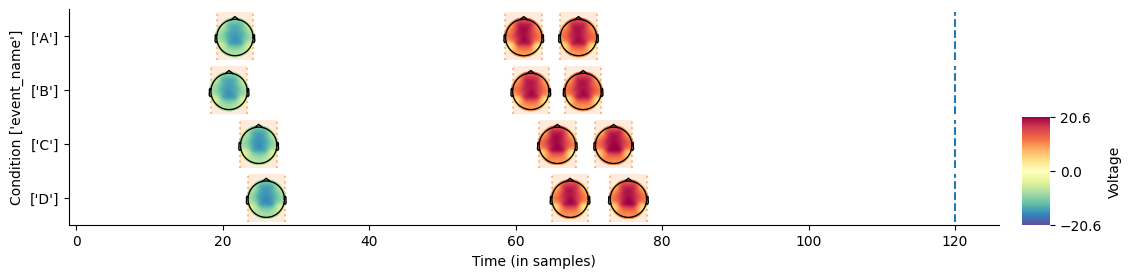

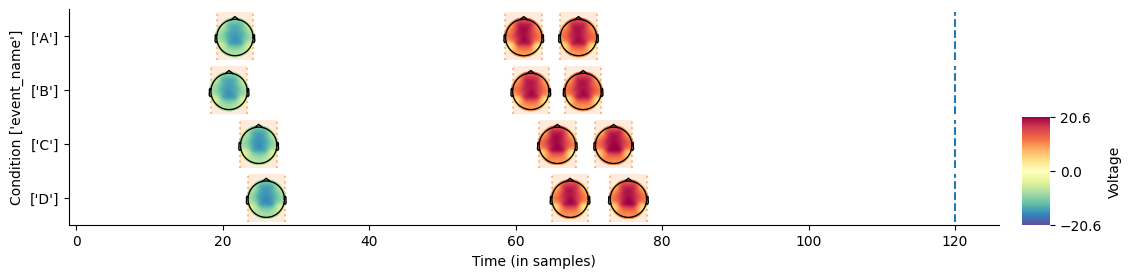

We recommend using cpus==1 unless you have *a lot* of memory and cpus available.
Estimating 3 events model
Estimating 3 events model
parameters estimated for 3 events model
Estimating 3 events model
parameters estimated for 3 events model
Estimating 3 events model
parameters estimated for 3 events model
Estimating 3 events model
parameters estimated for 3 events model
Estimating 3 events model
parameters estimated for 3 events model
Estimating 3 events model
parameters estimated for 3 events model
Estimating 3 events model
parameters estimated for 3 events model
Estimating 3 events model
parameters estimated for 3 events model
Estimating 3 events model
parameters estimated for 3 events model
Estimating 3 events model
parameters estimated for 3 events model
Estimating 3 events model
parameters estimated for 3 events model
Estimating 3 events model
parameters estimated for 3 events model
Estimating 3 events model
parameters estimated for 3 events model
Estimating 3 events model
parameter

/home/s4065832/.conda/envs/hmp/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1048: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean
/home/s4065832/.conda/envs/hmp/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1048: RuntimeWarning: invalid value encountered in subtract
  a_zero_mean = a - mean


6      None                     200                             6           -110.5
Estimating 6 events model
parameters estimated for 6 events model


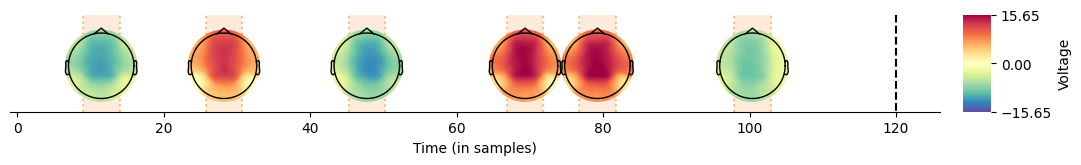

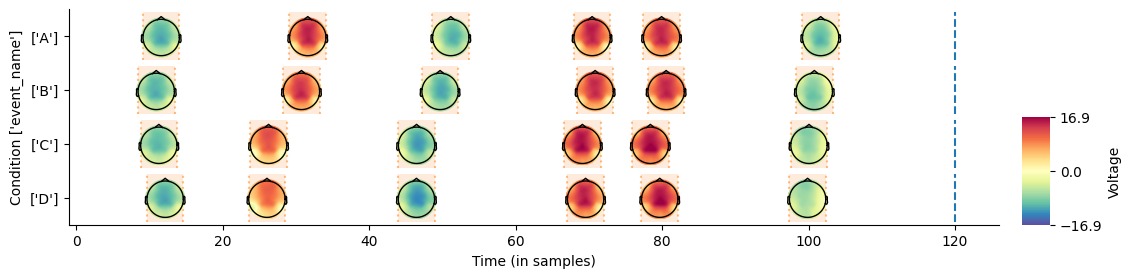

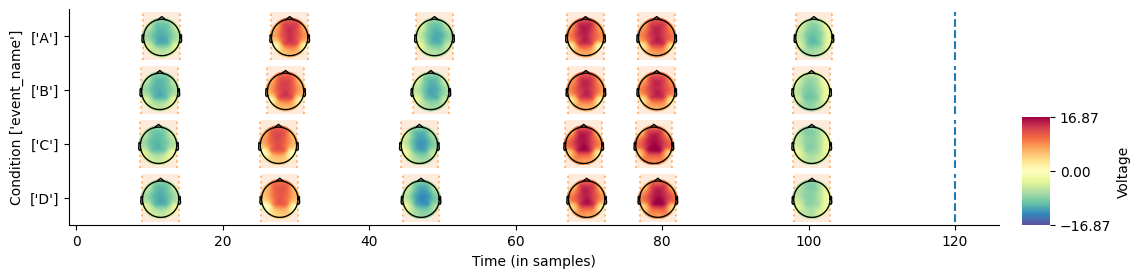

We recommend using cpus==1 unless you have *a lot* of memory and cpus available.
Estimating 6 events model
Estimating 6 events model
Estimating 6 events model
Estimating 6 events model
Estimating 6 events model
Estimating 6 events model
Estimating 6 events model
parameters estimated for 6 events model
Estimating 6 events model
Estimating 6 events model
parameters estimated for 6 events model
parameters estimated for 6 events model
Estimating 6 events model
Estimating 6 events model
parameters estimated for 6 events model
Estimating 6 events model
parameters estimated for 6 events model
Estimating 6 events model
Estimating 6 events model
parameters estimated for 6 events model
Estimating 6 events model
parameters estimated for 6 events model
parameters estimated for 6 events model
parameters estimated for 6 events model
parameters estimated for 6 events model
Estimating 6 events model
Estimating 6 events model
Estimating 6 events model
parameters estimated for 6 events model
Estimating 

In [24]:
print("shape, location_corr_threshold, location_corr_duration, max_events, likelihood")
for shape in parameters["shape"]:
    for location_corr_threshold in parameters["location_corr_threshold"]:
        for location_corr_duration in parameters["location_corr_duration"]:
            estimates = get_estimates(str(shape), str(location_corr_threshold), str(location_corr_duration))
            if estimates:
                max_events = get_max_event(estimates[0]["loo_likelihood"])
                means = np.nanmean(estimates[0]["loo_likelihood"].data,axis=1)[::-1]
                if means[max_events - 1] > -120:
                    print("{0:6} {1:24} {2:22} {3:10} {4:16}".format(str(shape), str(location_corr_threshold), str(location_corr_duration), max_events, round(means[max_events - 1], 1)))
                    # hmp.visu.plot_loocv(estimates[0]["loo_likelihood"], pvals=True, test='t-test', indiv=True, mean=True)
                    mags, params = get_mags_pars(estimates[1], max_events)
                    init = hmp.models.hmp(hmp_data, epoch_data, event_width=50, cpus=cpus, 
                                            shape =                   shape,
                                            location_corr_threshold = location_corr_threshold,
                                            location_corr_duration  = location_corr_duration)

                    # fit general model
                    general_model = general_loocv_model(init, mags, params, max_events)

                    # fit condition models
                    full_cond_model = cond_loocv_model(init, mags, params, "full", max_events)
                    half_cond_model = cond_loocv_model(init, mags, params, "half", max_events)

                    # plot topology of all models
                    plot_topos(epoch_data, general_model, info, init)
                    plot_topos(epoch_data, full_cond_model, info, init)
                    plot_topos(epoch_data, half_cond_model, info, init)

                    # general_model_likelihoods = hmp.loocv.loocv(init, hmp_data, general_model, cpus = cpus, verbose = False)
                    general_model_likelihoods = hmp.loocv.loocv_func(init, hmp_data, general_loocv_model, func_args = [mags, params, max_events], cpus = cpus, verbose = False)
                    full_cond_likelihoods = hmp.loocv.loocv_func(init, hmp_data, cond_loocv_model, func_args = [mags, params, "full", max_events], cpus = cpus, verbose = False)
                    half_cond_likelihoods = hmp.loocv.loocv_func(init, hmp_data, cond_loocv_model, func_args = [mags, params, "half", max_events], cpus = cpus, verbose = False)

                    print(np.mean(general_model_likelihoods[0]), np.mean(full_cond_likelihoods[0]), np.mean(half_cond_likelihoods[0]))
                    
                        
